In [1]:
from sympy import *
import matplotlib.pyplot as plt

init_printing()

In [2]:
c = [Matrix((x,)) for x in [(-1, 1), ( 0, 1), ( 1, 1), (-1, 0), ( 0, 0), ( 1, 0), (-1, 0), ( 0, -1), ( 1, -1)]]

In [3]:
c[1][1]

In [4]:
w = [Rational(*x) for x in [(1,36), (1,9), (1,36), (1,9), (4,9), (1,9), (1,36), (1,9), (1,36)]]

In [5]:
w

In [6]:
sum(w)

In [8]:
c_s = sqrt(Rational(1,3))
c_s

In [9]:
u_x, u_y, rho, tau = symbols('u_x u_y rho tau')

In [10]:
f_next = symarray('f_next', 9)
f_next

array([f_next_0, f_next_1, f_next_2, f_next_3, f_next_4, f_next_5,
       f_next_6, f_next_7, f_next_8], dtype=object)

In [11]:
f_curr = symarray('f_curr', 9)
f_curr

array([f_curr_0, f_curr_1, f_curr_2, f_curr_3, f_curr_4, f_curr_5,
       f_curr_6, f_curr_7, f_curr_8], dtype=object)

In [12]:
rho = sum(f_curr)
rho

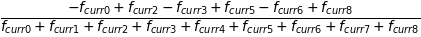

In [13]:
u_x = sum([ (c_i*f_curr[i])[0] for i, c_i in enumerate(c) ]) / rho
u_x

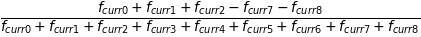

In [14]:
u_y = sum([ (c_i*f_curr[i])[1] for i, c_i in enumerate(c) ]) / rho
u_y

In [15]:
u = Matrix([u_x, u_y])
u

⎡                -f_curr_0 + f_curr_2 - f_curr_3 + f_curr_5 - f_curr_6 + f_cur
⎢─────────────────────────────────────────────────────────────────────────────
⎢f_curr_0 + f_curr_1 + f_curr_2 + f_curr_3 + f_curr_4 + f_curr_5 + f_curr_6 + 
⎢                                                                             
⎢                      f_curr_0 + f_curr_1 + f_curr_2 - f_curr_7 - f_curr_8   
⎢─────────────────────────────────────────────────────────────────────────────
⎣f_curr_0 + f_curr_1 + f_curr_2 + f_curr_3 + f_curr_4 + f_curr_5 + f_curr_6 + 

r_8                ⎤
───────────────────⎥
f_curr_7 + f_curr_8⎥
                   ⎥
                   ⎥
───────────────────⎥
f_curr_7 + f_curr_8⎦

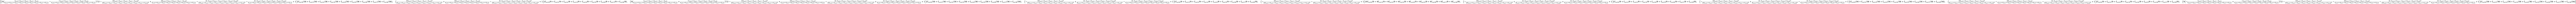

In [16]:
f_eq = []

for i, c_i in enumerate(c):
    f_eq_i = w[i] * rho * (  1
                           + c_i.dot(u)    /    c_s**2
                           + c_i.dot(u)**2 / (2*c_s**4)
                           - u.dot(u)      / (2*c_s**2) )
    f_eq.append(f_eq_i)

f_eq

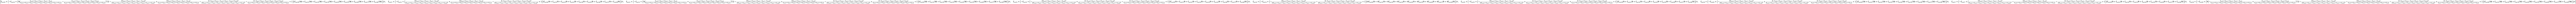

In [17]:
f_next = [ f_curr[i] + 1/tau * ( f_eq_i - f_curr[i] ) for i, f_eq_i in enumerate(f_eq) ]
f_next

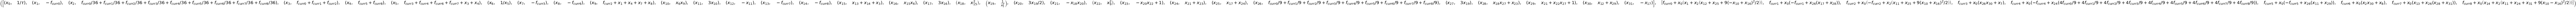

In [18]:
cse(f_next)

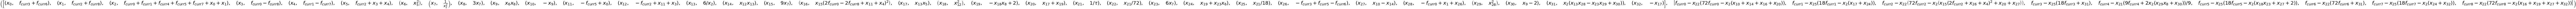

In [19]:
eqs = cse(f_next, optimizations='basic')
eqs

In [20]:
for eq in eqs[0]:
    print("%s = %s;" % (eq[0], eq[1]))

x0 = f_curr_3 + f_curr_6;
x1 = f_curr_2 + f_curr_8;
x2 = f_curr_0 + f_curr_1 + f_curr_4 + f_curr_5 + f_curr_7 + x0 + x1;
x3 = f_curr_0 - f_curr_8;
x4 = f_curr_1 - f_curr_7;
x5 = f_curr_2 + x3 + x4;
x6 = x5**2;
x7 = x2**(-2);
x8 = 3*x7;
x9 = x6*x8;
x10 = -x9;
x11 = -f_curr_5 + x0;
x12 = -f_curr_2 + x11 + x3;
x13 = 6/x2;
x14 = x12*x13;
x15 = 9*x7;
x16 = x15*(2*f_curr_0 - 2*f_curr_8 + x11 + x4)**2;
x17 = x13*x5;
x18 = x12**2;
x19 = -x18*x8 + 2;
x20 = x17 + x19;
x21 = 1/tau;
x22 = x21/72;
x23 = 6*x7;
x24 = x19 + x23*x6;
x25 = x21/18;
x26 = -f_curr_3 + f_curr_5 - f_curr_6;
x27 = x10 - x14;
x28 = -f_curr_0 + x1 + x26;
x29 = x28**2;
x30 = x9 - 2;
x31 = x2*(x13*x28 - x23*x29 + x30);
x32 = -x17;


In [21]:
for i, eq in enumerate(eqs[1]):
    print("f_next_%d = %s;" % (i, eq))

f_next_0 = f_curr_0 - x22*(72*f_curr_0 - x2*(x10 + x14 + x16 + x20));
f_next_1 = f_curr_1 - x25*(18*f_curr_1 - x2*(x17 + x24));
f_next_2 = f_curr_2 - x22*(72*f_curr_2 - x2*(x15*(2*f_curr_2 + x26 + x4)**2 + x20 + x27));
f_next_3 = f_curr_3 - x25*(18*f_curr_3 + x31);
f_next_4 = f_curr_4 - x21*(9*f_curr_4 + 2*x2*(x29*x8 + x30))/9;
f_next_5 = f_curr_5 - x25*(18*f_curr_5 - x2*(x18*x23 + x27 + 2));
f_next_6 = f_curr_6 - x22*(72*f_curr_6 + x31);
f_next_7 = f_curr_7 - x25*(18*f_curr_7 - x2*(x24 + x32));
f_next_8 = f_curr_8 - x22*(72*f_curr_8 - x2*(x16 + x19 + x27 + x32));
